/var/folders/qv/qpqwspdx2mn4zndqj91cxnkwzfytzl/T/ipykernel_15447/3542257025.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


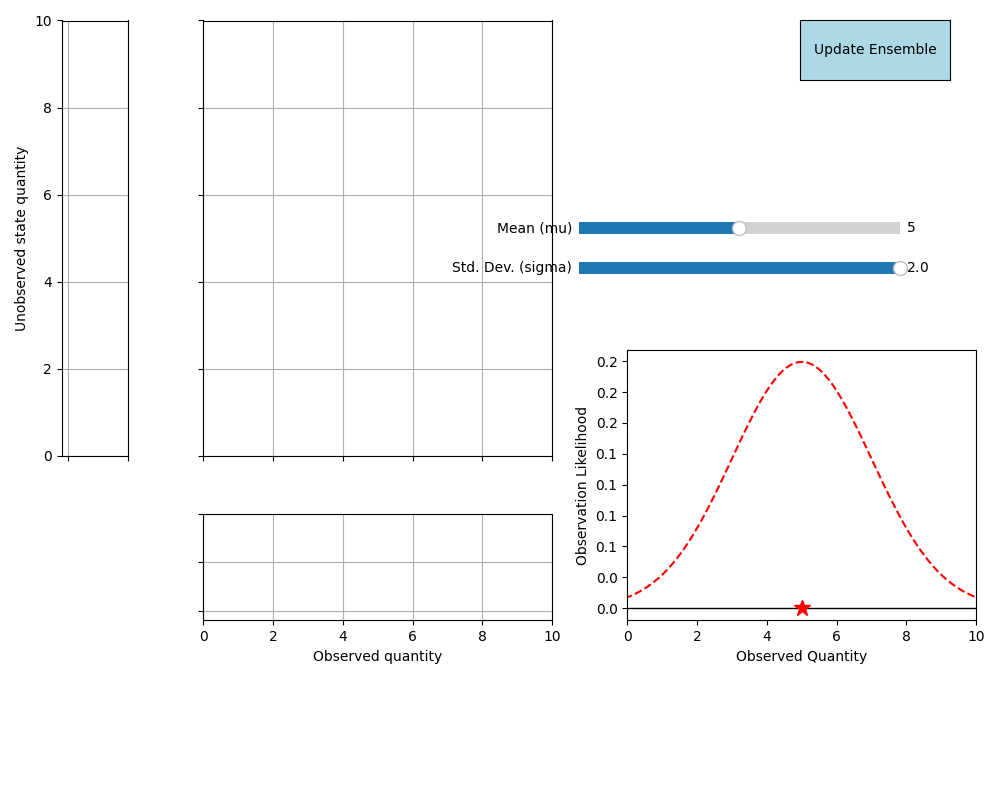

24

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Button
from matplotlib.widgets import Slider
import numpy as np
from matplotlib.ticker import FuncFormatter
%matplotlib widget

# Create figure
fig = plt.figure(figsize=(10, 8))
fig.canvas.header_visible = False

# Define GridSpec
gs = gridspec.GridSpec(5, 7, figure=fig)

# Create subplots of varying sizes and shapes
ax1 = fig.add_subplot(gs[0:3, 1:4]) # clicky main plot
ax2 = fig.add_subplot(gs[3, 1:4])   # Observered quantity
ax3 = fig.add_subplot(gs[0:3, 0])   # Unobserved state quantity
ax5 = fig.add_subplot(gs[2:4, 4:7]) # Marginal Distristribution of observation

ax5_position = ax5.get_position()
mu_intial = 5
sigma_initial = 2

# Customize each subplot
ax1.grid(True)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2.set_xlabel('Observed quantity')
ax2.grid(True)

slider_ax1 = plt.axes([ax5_position.x0+0.1, 0.7, ax5_position.width, 0.03])  # Adjust bottom as needed
slider_ax2 = plt.axes([ax5_position.x0+0.1, 0.65, ax5_position.width, 0.03])  # Adjust bottom as needed
# Creating sliders
mu_slider = Slider(slider_ax1, 'Mean (mu)', 0.0, 10.0, valinit=mu_intial)
sigma_slider = Slider(slider_ax2, 'Std. Dev. (sigma)', 0.1, 2.0, valinit=sigma_initial)  

# Define the update function
def update(val):
    mu = mu_slider.val
    sigma = sigma_slider.val
    ax5.clear()  # Clear the previous plot
    plot_observation(ax5, mu, sigma)  # Re-plot the observation with the new parameters
    plt.draw()  # Redraw the figure to reflect changes

# Connect the update function to the sliders
mu_slider.on_changed(update)  
sigma_slider.on_changed(update) 

ax3.set_ylabel('Unobserved state quantity')
ax3.grid(True)

# Get the limits of ax1
x_limits_ax1 = ax1.get_xlim()
y_limits_ax1 = ax1.get_ylim()

# Set the limits of ax2, ax3 to match those of ax1
ax2.set_xlim(x_limits_ax1)
ax2.set_ylim(-0.1, 1)
ax2.set_yticklabels([])

ax3.set_xlim(-0.1, 1)
ax3.set_ylim(y_limits_ax1)
ax3.set_xticklabels([])

# Define a custom formatter function
def hide_negative_numbers(x, pos):
    """Hide negative numbers on an axis."""
    if x < 0:
        return ''
    return f'{x:.1f}'

# Observation
def plot_observation(ax, mu, sigma):
    # Define the normal distribution parameters
    #mu = 5  # mean
    #sigma = 1  # standard deviation

    # Generate x values
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

    # Compute y values for the normal distribution
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=1)
    ax.set_xlim(x_limits_ax1)
    #ax.set_ylim(bottom=-0.1)  # this is also causing the top limit to be 1
    # Apply the custom formatter to the y-axis of ax3
    ax.yaxis.set_major_formatter(FuncFormatter(hide_negative_numbers))
    ax.plot(x,y, linestyle='--', color='r')
    ax.plot(mu, 0, 'r*', markersize=12)
    ax.set_xlabel('Observed Quantity')
    ax.set_ylabel('Observation Likelihood')

plot_observation(ax5, mu=mu_intial, sigma=sigma_initial)

# Create a button axes
button_ax = plt.axes([0.8, 0.9, 0.15, 0.075])  # Adjust the position and size as needed
button = Button(button_ax, 'Update Ensemble', color='lightblue', hovercolor='0.975')

# Define the event handler
def update_ensemble(event):
    # Check if there are fewer than 2 clicked points
    if len(clicked_points) < 2:
        print("Need at least 2 points to update ensemble.")
        return  # Exit the function early
    
    # Rest of your function code follows...
    # Use zip and the * operator to unzip the list of tuples into two lists
    x_list, y_list = zip(*clicked_points)

    # Convert the tuples to lists 
    x_list = list(x_list)
    y_list = list(y_list)

    # plot the best fit line
    # Calculate the best fit line parameters: slope (m) and intercept (b)
    m, b = np.polyfit(x_list, y_list, 1)  # 1 means linear (first-degree polynomial)

    # Generate x values for the line: from the minimum to the maximum x value in clicked_points
    x_line = np.linspace(0, 10, 100)  # 100 points for a smooth line

    # Calculate corresponding y values based on the line equation y = mx + b
    y_line = m * x_line + b

    # Plot the line on ax1 (or any other subplot as needed)
    ax1.plot(x_line, y_line, 'g-', label='Best Fit Line')  # 'r-' for a red line

    # this is a stand in for the ensemble kalman filter update
    updated_x = [x+0.5 for x in x_list]
    updated_y = [y+0.5 for y in y_list]

    ax1.plot(updated_x, updated_y, 'b*')  # Plot the updated points
    z = [0.1] * len(updated_x) 
    dz = 1 / (len(updated_x) +1)
    z_plot = [element + dz*i for i, element in enumerate(z)]
    obs_z = [x * -0.1 for x in z_plot]
    
    # plot updated points on marginals
    ax2.plot(updated_x, z_plot, 'b*')
    ax3.plot(z_plot, updated_y, 'b*')
    ax5.plot(updated_x, obs_z, 'b*')
    

    # plot increment lines
    for i, _ in enumerate(updated_x):
        ax2.plot([x_list[i], updated_x[i]], [z_plot[i], z_plot[i]], 'b-')
        ax3.plot([z_plot[i], z_plot[i]], [y_list[i], updated_y[i]], 'b-')
        ax5.plot([x_list[i], updated_x[i]], [obs_z[i], obs_z[i]], 'b-')

    plt.draw()  # Redraw the figure to reflect changes

# Connect the event handler
button.on_clicked(update_ensemble)

plt.tight_layout()
plt.show()

# Initialize an empty list to store the points
clicked_points = []

def on_click(event):
    # Check if the click was on ax1
    if event.inaxes == ax1:
        # Append the clicked point (xdata, ydata) to the list
        clicked_points.append((event.xdata, event.ydata))
        print(f"Clicked at x={event.xdata}, y={event.ydata}")
        # Plot the click coordinates on ax1
        ax1.plot(event.xdata, event.ydata, 'go')  # 'ro' plots a red dot
        ax2.plot(event.xdata, 0, 'g*')
        ax3.plot(0, event.ydata, 'g*')
        ax5.plot(event.xdata, 0, 'g*')
        plt.draw()  # Update the plot with the new point

# Connect the event handler to the figure
fig.canvas.mpl_connect('button_press_event', on_click)
